In [ ]:
!pip install gym~=0.17.3
!pip install numpy==1.19.4
!pip install boolean.py@git+https://github.com/bastikr/boolean.py/@74063a8588875c058e6dbbb85b69ed052e1f2099#egg=boolpy_stubs
!pip install networkx==2.4
!pip install pyyaml~=5.4.1
!pip install setuptools~=49.2.1
!pip install matplotlib~=3.2.1
!pip install plotly~=4.11.0
!pip install tabulate~=0.8.7
!pip install ordered_set==4.0.2
!pip install progressbar2==3.51.4
!pip install decorator==4.3

In [1]:
import sys
import math
import random
import progressbar
import numpy as np
from time import time
from copy import deepcopy
from typing import TypedDict
from itertools import combinations

import cyberbattle._env.cyberbattle_env
import cyberbattle.agents.baseline.agent_wrapper as w
from cyberbattle.simulation import actions, model
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, Action, DefenderConstraint

import gym
from gym.utils import seeding

# gym_env = gym.make('CyberBattleToyCtf-v0', attacker_goal=AttackerGoal(own_atleast=6))

# gym_env = gym.make('CyberBattleToyCtf-v0', attacker_goal=AttackerGoal(own_atleast_percent=0.6, low_availability=0.4))

gym_env = gym.make('CyberBattleChain-v0', size=10, attacker_goal=AttackerGoal(own_atleast_percent=1.0))

# gym_env = gym.make('CyberBattleChain-v0', size=10, attacker_goal=AttackerGoal(own_atleast_percent=0.8),
#                     defender_constraint=DefenderConstraint(maintain_sla=0.80),
#                     defender_agent=ScanAndReimageCompromisedMachines(probability=0.6,scan_capacity=2,scan_frequency=5))

import logging
# logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")

In [2]:
def action_to_string(action):
    key, value = list(action.items())[0][0], list(action.items())[0][1]
    action_str = f"{key}-{list(value)}"
    return action_str

def string_to_action(action_str):
    key, value_str = action_str.split('-')
    if key == 'connect':
        _val = eval(value_str)
        value = np.array(_val, np.int32)
        return Action(connect=value)
    elif key == 'local_vulnerability':
        _val = eval(value_str)
        value = np.array(_val, np.int32)
        return Action(local_vulnerability=value)
    else:
        _val = eval(value_str)
        value = np.array(_val, np.int32)
        return Action(remote_vulnerability=value)
    
def convert_to_action(env, action):
    for k in action.keys():
        if k == 'connect':
            atk_detail_node = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][0])
            atk_detail_target = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][1])
            atk_detail_port = env._CyberBattleEnv__index_to_port_name(list(action.values())[0][2])
            atk_detail_cred = env._CyberBattleEnv__credential_cache[list(action.values())[0][3]]
            return f'Attack Type: {k}\nFrom Node: {atk_detail_node}\nTarget Node: {atk_detail_target}\nOn Port: {atk_detail_port}\nCredentials: {atk_detail_cred}\n'
        elif k == 'local_vulnerability':
            atk_detail_node = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][0])
            atk_detail_atk = env._CyberBattleEnv__index_to_local_vulnerabilityid(list(action.values())[0][1])
            return f'Attack Type: {k}\nFrom Node: {atk_detail_node}\nAttack Type: {atk_detail_atk}\n'
        else:
            atk_detail_node = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][0])
            atk_detail_target = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][1])
            atk_detail_atk = env._CyberBattleEnv__index_to_remote_vulnerabilityid(list(action.values())[0][2])
            return f'Attack Type: {k}\nFrom Node: {atk_detail_node}\nTarget Node: {atk_detail_target}\nAttack Type: {atk_detail_atk}\n'

In [3]:
def randomPolicy(state, random, bar):
    '''
    Policy followed in MCTS simulation for playout
    '''
    reward = 0.
    action_list = list(state.getActions())
    while not state.isDone():
        action = random.choice(action_list)
        state = state.simulateStep(action=action)
        reward += state.getReward()
        action_list = list(state.getActions())
        bar.update(bar.value+1)
    return reward

In [4]:
class NetworkState():
    def __init__(self, state, env=None, taken_before=set(), done=False, reward=0):
        '''
        Data structure to represent state of the environment
        self.env : Environment of gym_network_environment simulator
        self.state : State of the gym_network_environment
        self.is_done : Denotes whether the NetworkState is terminal
        self.num_lanes : Number of nodes in gym_network_environment
        self.width : Width of lanes in gym_network_environment
        self.reward : Reward of the state
        '''
        self.state = state
        self.env = deepcopy(env)
        self.is_done = done
        self.reward = reward
        
        self.actions_taken_before = taken_before
        
    def simulateStep(self, action):
        '''
        Simulates action at self.state and returns the next state
        '''
        env = deepcopy(self.env)
        observation, reward, done, info = env.step(action=action)
        _actions_before = deepcopy(self.actions_taken_before)
        _actions_before.add(action_to_string(action))
        newState = NetworkState(observation, env=env, taken_before=_actions_before, done=done, reward=reward)
        return newState

    def isDone(self):
        '''
        Returns whether the state is terminal
        '''
        return self.is_done

    def getReward(self):
        '''
        Returns reward of the state
        '''
        return self.reward
    
    def getActions(self):
        _actions = []
        
        # AgentActions
        env_actions = actions.AgentActions(self.env._CyberBattleEnv__environment)
        
        # Get Source Node
        potential_source_nodes = w.owned_nodes(self.state)
        client_node = potential_source_nodes[0]
        source_node_names = {self.env._CyberBattleEnv__internal_node_id_from_external_node_index(node):node for node in potential_source_nodes}
        
        # Get Target Node
        nodes_not_owned = w.discovered_nodes_notowned(self.state)
        target_node_names = {node:i for i, node in enumerate(self.env._CyberBattleEnv__discovered_nodes)}
        
        
        # Connect
        discovered_credentials = np.array(self.state['credential_cache_matrix'])
        n_discovered_creds = len(discovered_credentials)
        if n_discovered_creds > 0:
            match_port__target_notowned = [c for c in range(n_discovered_creds)
                                           if discovered_credentials[c, 0] in nodes_not_owned]
            
            if match_port__target_notowned:
                cred = np.int32(np.random.choice(match_port__target_notowned))
                target = np.int32(discovered_credentials[cred, 0])
                port = np.int32(discovered_credentials[cred, 1])
                for source_node in potential_source_nodes:
                    _actions.append(Action(connect=np.array([client_node, target, port, cred], dtype=np.int32)))
                ## For other ports
                for source_node in potential_source_nodes:
                    for port in range(self.env._CyberBattleEnv__bounds.port_count):
                        _actions.append(Action(connect=np.array([source_node, target, port, cred], dtype=np.int32)))

        
        # Remote Vulnerability
        num_of_remote_vuls = self.env._CyberBattleEnv__bounds.remote_attacks_count
        all_remote_vul = {self.env._CyberBattleEnv__index_to_remote_vulnerabilityid(atk_id):atk_id for atk_id in range(num_of_remote_vuls)}

        for node_name, t_node in target_node_names.items():
            for atk in env_actions.list_vulnerabilities_in_target(node_name, model.VulnerabilityType.REMOTE):
                remote_atk = all_remote_vul[atk]
                _actions.append(Action(remote_vulnerability=np.array([client_node, t_node, remote_atk], dtype=np.int32)))
        
        
        # Local Vulnerability
        num_of_local_vuls = self.env._CyberBattleEnv__bounds.local_attacks_count
        all_local_vul = {self.env._CyberBattleEnv__index_to_local_vulnerabilityid(atk_id):atk_id for atk_id in range(num_of_local_vuls)}

#         local_vuls = {node_name:self.env._CyberBattleEnv__environment.get_node(node_name).vulnerabilities for node_name in node_names}
        
        for node_name, s_node in source_node_names.items():
            for atk in env_actions.list_vulnerabilities_in_target(node_name, model.VulnerabilityType.LOCAL):
                local_atk = all_local_vul[atk]
                _actions.append(Action(local_vulnerability=np.array([s_node, local_atk], dtype=np.int32)))
        
        
        # Get unique and untaken actions
        uniq_actions = []
        for action in _actions:
            if self.env.is_action_valid(action, self.state['action_mask']):
                action_str = action_to_string(action)
                if action_str not in self.actions_taken_before and action_str not in uniq_actions:
                    uniq_actions.append(action_str)
        uniq_actions = [string_to_action(action_str) for action_str in uniq_actions]

        debug=False
        if debug:
            print(f'\nallactions: {_actions}')
            print(f'uniqactions: {uniq_actions}')
            print(f'priviledge level: {self.state["nodes_privilegelevel"]}')
            print(f'source_node_names: {source_node_names}')
            print(f'target_node_names: {target_node_names}')
            print(f'nodes_not_owned: {nodes_not_owned}')
            print(f'discovered_credentials: {discovered_credentials}')
            try:
                print(f'match_port__target_notowned: {match_port__target_notowned}')
            except:
                print('None')
            print(f'all_remote_vul: {all_remote_vul}')
            print(f'all_local_vul: {all_local_vul}')
            print(f'actions_taken_before: {self.actions_taken_before}\n')
        
        return uniq_actions

In [5]:
class Node:
    def __init__(self, state, parent=None):
        '''
        Data structure for a node of the MCTS tree
        self.state : GridWorld state represented by the node
        self.parent : Parent of the node in the MCTS tree
        self.numVisits : Number of times the node has been visited
        self.totalReward : Sum of all rewards backpropagated to the node
        self.isDone : Denotes whether the node represents a terminal state
        self.allChildrenAdded : Denotes whether all actions from the node have been explored
        self.children : Set of children of the node in the MCTS tree
        '''
        self.state = state
        self.parent = parent
        self.numVisits = 0
        self.totalReward = state.reward #0
        self.isDone = state.isDone()
        self.allChildrenAdded = state.isDone()
        self.children = {}

In [6]:
class MonteCarloTreeSearch(object):
    def __init__(self, numiters, explorationParam, playoutPolicy=randomPolicy, env=None, random_seed=None):
        '''
        self.numiters : Number of MCTS iterations
        self.explorationParam : exploration constant used in computing value of node
        self.playoutPolicy : Policy followed by agent to simulate rollout from leaf node
        self.root : root node of MCTS tree
        '''
        self.env = env
        self.numiters = numiters
        self.explorationParam = explorationParam
        self.playoutPolicy = playoutPolicy
        self.root = None
        self.random, self.seed = seeding.np_random(random_seed)
        
        self._steps_taken = None

    def buildTreeAndReturnBestAction(self, initialState, bar):
        '''
        Function to build MCTS tree and return best action at initialState
        '''
        self.root = Node(state=initialState, parent=None)
        self._steps_taken = 0
        for i in range(self.numiters):
#             print(f'\n Iteration {i}\n')
            self.addNodeAndBackpropagate(bar)
        bestChild = self.chooseBestActionNode(self.root, 0)
        for action_str, cur_node in self.root.children.items():
            if cur_node is bestChild:
                action = string_to_action(action_str)
                return action, self._steps_taken/self.numiters

    def addNodeAndBackpropagate(self, bar):
        '''
        Function to run a single MCTS iteration
        '''
        node = self.addNode(bar)
        _tmp = bar.value-1
        reward = self.playoutPolicy(node.state, self.random, bar)
        self._steps_taken += bar.value-_tmp
        self.backpropagate(node, reward)

    def addNode(self, bar):
        '''
        Function to add a node to the MCTS tree
        '''
        cur_node = self.root
        bar.update(bar.value+1)
        while not cur_node.isDone:
            if cur_node.allChildrenAdded:
                cur_node = self.chooseBestActionNode(cur_node, self.explorationParam)
            else:
                actions_list = cur_node.state.getActions()
                for action in actions_list:
                    
                    # Convert action to action string
                    action_str = action_to_string(action)
                    
                    # Check if invalid actions or already a tried action
                    if action_str not in cur_node.children:
                        childnode = cur_node.state.simulateStep(action=action)
                        newNode = Node(state=childnode, parent=cur_node)
                        cur_node.children[action_str] = newNode
                        if len(actions_list) == len(cur_node.children):
                            cur_node.allChildrenAdded = True
                        return newNode
    
        return cur_node

    def backpropagate(self, node, reward):
        '''
        FILL ME : This function should implement the backpropation step of MCTS.
                  Update the values of relevant variables in Node Class to complete this function
        '''
        while True:
            # Add values to node
            node.totalReward += reward
            node.numVisits += 1

            # Terminating Condition
            if node.parent is None:
                break

            # Go to parent node
            node = node.parent

    def chooseBestActionNode(self, node, explorationValue):
        random = self.random
        bestValue = float("-inf")
        bestNodes = []
        for child in node.children.values():
            '''
            FILL ME : Populate the list bestNodes with all children having maximum value

                       Value of all nodes should be computed as mentioned in question 3(b).
                       All the nodes that have the largest value should be included in the list bestNodes.
                       We will then choose one of the nodes in this list at random as the best action node.
            '''
            # Get Child values
            try:
                child_value = (child.totalReward/child.numVisits) + \
                    explorationValue * math.sqrt((math.log(node.numVisits) / child.numVisits))
            except ZeroDivisionError:  # Case if division by zero
                child_value = 0

            # Case if child value more than best value
            if child_value > bestValue:
                bestNodes = [child,]
                bestValue = child_value
            elif child_value == bestValue:  # Case if child value is best value
                bestNodes.append(child)

        return random.choice(bestNodes)

In [7]:
### Execute runs ###

## Stats Records ##
# Stats = TypedDict('Records', {
#     'Rewards': List[List[float]],
#     'Time Taken': List[List[float]],
#     'Actions': List[List[str]],
# })

## Random seeding ##
RANDOM_SEED = 10

reward_records = []
time_records = []
action_records = []

for iter_i in range(1,10):
    
    ## Progressbar widgets ##
    _widgets = ['Episode ', f'{iter_i}',
                '|Iteration ', progressbar.Counter(),
                '|', progressbar.Variable(name='reward', width=6, precision=10),
                '|', progressbar.Variable(name='last_reward_at', width=4),
                '|', progressbar.Variable(name='last_reward_value', width=3),
                '|', progressbar.Timer(),
                progressbar.Bar()]
    
    bar = progressbar.ProgressBar(
            widgets=_widgets,
            redirect_stdout=True,
            max_value=progressbar.UnknownLength)
    
    ## Environment parameters to reset ##
    done = False
    state = gym_env.reset()
    mcts = MonteCarloTreeSearch(env=deepcopy(gym_env), numiters=iter_i, explorationParam=1., random_seed=RANDOM_SEED)
    
    reward_record = []
    time_record = []
    action_record = []
    taken_actions = set()
    
    while True:  
        net_state = NetworkState(state, env=gym_env, taken_before=taken_actions, done=done)

        start_time = time()
        action, pad_rewards = mcts.buildTreeAndReturnBestAction(initialState=net_state, bar=bar)
        time_elapsed = time() - start_time
        time_record.append(time_elapsed)

        printable_action = convert_to_action(gym_env, action)
        action_record.append(printable_action)
        taken_actions.add(action_to_string(action))
        
        state, reward, done, info = gym_env.step(action)
        
        for _ in range(int(pad_rewards)):
            reward_record.append(0.0)
        reward_record.append(reward)
        
        bar.update(bar.value+1)
        bar.update(bar.value, reward=sum(reward_record))
        
        if reward>0:
            bar.update(bar.value, last_reward_at=bar.value, last_reward_value=reward)
#             print(f'Step {i}')
#             print(f'####### rewarded action: \n{printable_action}\n')
#             print(f'total_reward={sum(reward_record)} reward={reward}\n')
#             gym_env.render()

        if done == True:
            bar.finish(dirty=True)
            break

    sys.stdout.flush()
    reward_records.append(reward_record)
    time_records.append(time_record)
    action_records.append(action_record)
    
print ("simulation done")

Episode 1|Iteration 5641|reward: 6243.0|last_reward_at: 5641|last_reward_value: 5e+03|Elapsed Time: 0:02:18|#|
Episode 2|Iteration 12873|reward: 6249.0|last_reward_at: 12873|last_reward_value: 5e+03|Elapsed Time: 0:05:29|#|
Episode 3|Iteration 20907|reward: 6251.0|last_reward_at: 20907|last_reward_value: 5e+03|Elapsed Time: 0:08:30|#|
Episode 4|Iteration 30223|reward: 6249.0|last_reward_at: 30223|last_reward_value: 5e+03|Elapsed Time: 0:07:37|#|
Episode 5|Iteration 36779|reward: 6247.0|last_reward_at: 36779|last_reward_value: 5e+03|Elapsed Time: 0:08:32|#|
Episode 6|Iteration 50597|reward: 6241.0|last_reward_at: 50597|last_reward_value: 5e+03|Elapsed Time: 0:10:58|#|
Episode 7|Iteration 59954|reward: 6247.0|last_reward_at: 59954|last_reward_value: 5e+03|Elapsed Time: 0:14:05|#|
Episode 8|Iteration 63951|reward: 6251.0|last_reward_at: 63951|last_reward_value: 5e+03|Elapsed Time: 0:16:09|#|
Episode 9|Iteration 82593|reward: 6247.0|last_reward_at: 82593|last_reward_value: 5e+03|Elapsed Ti

simulation done


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def new_plot(title):
    """Prepare a new plot of cumulative rewards"""
    plt.figure(figsize=(10, 8))
    plt.ylabel('cumulative reward', fontsize=20)
    plt.xlabel('step', fontsize=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title(title, fontsize=12)


def pad(array, length):
    """Pad an array with 0s to make it of desired length"""
    padding = np.zeros((length,))
    padding[:len(array)] = array
    return padding

def plot_episodes_rewards_averaged(results, title):
    """Plot cumulative rewards for a given set of specified episodes"""
    max_iteration_count = np.max([len(r) for r in results])

    all_episodes_rewards_padded = [pad(rewards, max_iteration_count) for rewards in results]
    cumrewards = np.cumsum(all_episodes_rewards_padded, axis=1)
    print(list(map(lambda x: x[-1], cumrewards)))
    avg = np.average(cumrewards, axis=0)
#     print(avg)
    std = np.std(cumrewards, axis=0)
#     print(std)
    x = [i for i in range(len(std))]
#     print(x)
    plt.plot(x, avg, label=title)
    plt.fill_between(x, avg - std, avg + std, alpha=0.5)
    
def plot_episodes_length(learning_results, title):
    """Plot length of every episode"""
    plt.figure(figsize=(10, 8))
    plt.ylabel('#iterations', fontsize=20)
    plt.xlabel('episode', fontsize=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Length of each episode", fontsize=12)

    for results in learning_results:
        iterations = [len(e) for e in results['all_episodes_rewards']]
        episode = [i for i in range(len(results['all_episodes_rewards']))]
        plt.plot(episode, iterations, label=results['title'])

    plt.legend(loc="upper right")
    plt.show()
    
def plot_each_episode(results):
    """Plot cumulative rewards for each episode"""
    for i, episode in enumerate(results['all_episodes_rewards']):
        cumrewards = np.cumsum(episode)
        x = [i for i in range(len(cumrewards))]
        plt.plot(x, cumrewards, label=f'Episode {i}')


def plot_all_episodes(r):
    """Plot cumulative rewards for every episode"""
    new_plot(r['title'])
    plot_each_episode(r)
    plt.legend(loc="lower right")
    plt.show()

In [9]:
sum(time_records[-1])

1169.6352400779724

In [10]:
len(reward_records[0])

5641

In [12]:
trimmed_rewards = list(map(lambda x: x[:-1], reward_records))

In [51]:
action_records[0]

['Attack Type: local_vulnerability\nFrom Node: client\nAttack Type: SearchEdgeHistory\n',
 'Attack Type: remote_vulnerability\nFrom Node: client\nTarget Node: Website\nAttack Type: ScanPageSource\n',
 'Attack Type: remote_vulnerability\nFrom Node: client\nTarget Node: Website\nAttack Type: ScanPageContent\n',
 'Attack Type: remote_vulnerability\nFrom Node: client\nTarget Node: Website.Directory\nAttack Type: NavigateWebDirectory\n',
 'Attack Type: remote_vulnerability\nFrom Node: client\nTarget Node: Website.Directory\nAttack Type: NavigateWebDirectoryFurther\n',
 "Attack Type: connect\nFrom Node: client\nTarget Node: Website\nOn Port: MySQL\nCredentials: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')\n",
 "Attack Type: connect\nFrom Node: client\nTarget Node: Website\nOn Port: GIT\nCredentials: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')\n",
 "Attack Type: connect\nFrom Node: client\nTarget Node: Website\nOn Port: 

[1243.0, 1249.0, 1251.0, 1249.0, 1247.0, 1241.0, 1247.0, 1251.0, 1247.0]


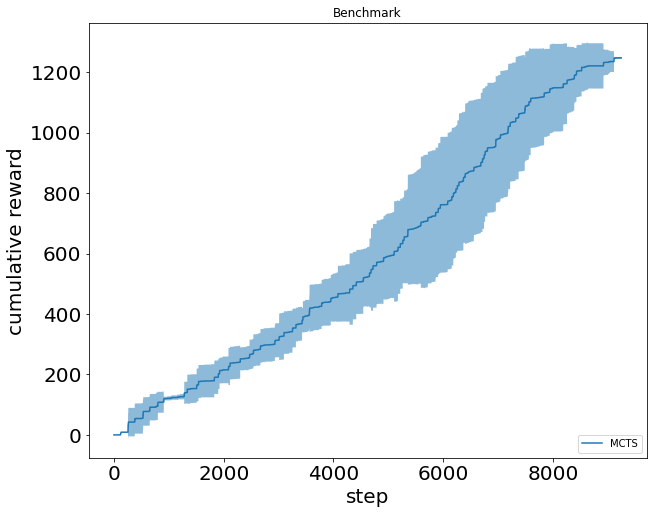

In [13]:
new_plot('Benchmark')
plot_episodes_rewards_averaged(trimmed_rewards, 'MCTS')
plt.legend(loc="lower right")
plt.show()

In [40]:
import pickle

all_runs = [
    {'all_episodes_rewards': credlookup_run['all_episodes_rewards'], 'title':'credlookup_run'}, 
    {'all_episodes_rewards': random_run['all_episodes_rewards'], 'title':'random_run'}, 
    {'all_episodes_rewards': tabularq_run['all_episodes_rewards'], 'title':'tabularq_run'}, 
    {'all_episodes_rewards': tabularq_exploit_run['all_episodes_rewards'], 'title':'tabularq_exploit_run'},
    {'all_episodes_rewards': trimmed_rewards, 'title':'mcts_run'},
    {'all_episodes_rewards': dql_run['all_episodes_rewards'], 'title':'dql_run'},
    {'all_episodes_rewards': dql_exploit_run['all_episodes_rewards'], 'title':'dql_exploit_run'}
]

pickle.dump({'action':action_records, 'reward':reward_records, 'time': time_records, 'gym_env': gym_env,
             'others':all_runs, 
            }, open('cs4246/Chain_records', 'wb'))

In [15]:
gym_env.render()

id status                                 properties  \
0            start  owned                                         []   
1      1_LinuxNode  owned              [MySql, Ubuntu, nginx/1.10.3]   
2    2_WindowsNode  owned             [Windows, Win10, Win10Patched]   
3      3_LinuxNode  owned              [MySql, Ubuntu, nginx/1.10.3]   
4    4_WindowsNode  owned             [Windows, Win10, Win10Patched]   
5      5_LinuxNode  owned              [MySql, Ubuntu, nginx/1.10.3]   
6    6_WindowsNode  owned             [Windows, Win10, Win10Patched]   
7      7_LinuxNode  owned              [MySql, Ubuntu, nginx/1.10.3]   
8    8_WindowsNode  owned             [Windows, Win10, Win10Patched]   
9      9_LinuxNode  owned              [MySql, Ubuntu, nginx/1.10.3]   
10  10_WindowsNode  owned             [Windows, Win10, Win10Patched]   
11    11_LinuxNode  owned  [MySql, Ubuntu, nginx/1.10.3, FLAG:Linux]   

                                        local_attacks  \
0                           [ScanExplorerRecentFiles]   
1   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
2   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
3   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
4   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
5   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
6   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
7   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
8   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
9   [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
10  [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
11                                                 []   

                remote_attacks  
0                           []  
1   [ProbeWindows, ProbeLinux]  
2   [ProbeWindows, ProbeLinux]  
3   [ProbeWindows, ProbeLinux]  
4   [ProbeWindows, ProbeLinux]  
5   [ProbeWindows, ProbeLinux]  
6   [ProbeWindows, ProbeLinux]  
7   [ProbeWindows, ProbeLinux]  
8   [ProbeWindows, ProbeLinux]  
9   [ProbeWindows, ProbeLinux]  
10  [ProbeWindows, ProbeLinux]  
11                          []

In [16]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

"""Benchmark all the baseline agents
on a given CyberBattleSim environment and compare
them to the dumb 'random agent' baseline.

NOTE: You can run this `.py`-notebook directly from VSCode.
You can also generate a traditional Jupyter Notebook
using the VSCode command `Export Currenty Python File As Jupyter Notebook`.
"""

# pylint: disable=invalid-name

"Benchmark all the baseline agents\non a given CyberBattleSim environment and compare\nthem to the dumb 'random agent' baseline.\n\nNOTE: You can run this `.py`-notebook directly from VSCode.\nYou can also generate a traditional Jupyter Notebook\nusing the VSCode command `Export Currenty Python File As Jupyter Notebook`.\n"

In [17]:
import sys
import logging
import gym
import cyberbattle.agents.baseline.learner as learner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_tabularqlearning as tqa
import cyberbattle.agents.baseline.agent_dql as dqla
from cyberbattle.agents.baseline.agent_wrapper import Verbosity

logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

In [3]:
# Papermill notebook parameters

#############
# gymid = 'CyberBattleTiny-v0'
#############
gymid = "CyberBattleToyCtf-v0"
env_size = None
iteration_count = 1500
training_episode_count = 20
eval_episode_count = 10
maximum_node_count = 12
maximum_total_credentials = 10
#############
# gymid = "CyberBattleChain-v0"
# env_size = 10
# iteration_count = 9000
# training_episode_count = 50
# eval_episode_count = 5
# maximum_node_count = 22
# maximum_total_credentials = 22

In [18]:
# Parameters
gymid = "CyberBattleChain-v0"
iteration_count = 9000
training_episode_count = 50
eval_episode_count = 5
maximum_node_count = 22
maximum_total_credentials = 22
env_size = 10


In [22]:
# Load the Gym environment
# if env_size:
#     gym_env = gym.make(gymid, size=env_size)
# else:
#     gym_env = gym.make(gymid)

gym_env.reset()

ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=maximum_node_count,
    maximum_total_credentials=maximum_total_credentials,
    identifiers=gym_env.identifiers
)

In [20]:
debugging = False
if debugging:
    print(f"port_count = {ep.port_count}, property_count = {ep.property_count}")

    gym_env.environment
    # training_env.environment.plot_environment_graph()
    gym_env.environment.network.nodes
    gym_env.action_space
    gym_env.action_space.sample()
    gym_env.observation_space.sample()
    o0 = gym_env.reset()
    o_test, r, d, i = gym_env.step(gym_env.sample_valid_action())
    o0 = gym_env.reset()

    o0.keys()

    fe_example = w.RavelEncoding(ep, [w.Feature_active_node_properties(ep), w.Feature_discovered_node_count(ep)])
    a = w.StateAugmentation(o0)
    w.Feature_discovered_ports(ep).get(a, None)
    fe_example.encode_at(a, 0)

###### Credential lookups (ϵ-greedy)
Learning with: episode_count=10,iteration_count=9000,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=10000,
  ## Episode: 1/10 'Credential lookups (ϵ-greedy)' ϵ=0.9000, 


Episode 1|Iteration 620|reward: 6249.0|last_reward_at:  620|Elapsed Time: 0:00:01||


  Episode 1 ended at t=620 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/217 (0.09)
    explore-remote: 20/351 (0.05)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 56
  ## Episode: 2/10 'Credential lookups (ϵ-greedy)' ϵ=0.8520, 


Episode 2|Iteration 392|reward: 6247.0|last_reward_at:  392|Elapsed Time: 0:00:00||


  Episode 2 ended at t=392 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/139 (0.13)
    explore-remote: 20/201 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 52
  ## Episode: 3/10 'Credential lookups (ϵ-greedy)' ϵ=0.8231, 


Episode 3|Iteration 403|reward: 6233.0|last_reward_at:  403|Elapsed Time: 0:00:00||


  Episode 3 ended at t=403 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 20/169 (0.11)
    explore-remote: 19/184 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 52
  ## Episode: 4/10 'Credential lookups (ϵ-greedy)' ϵ=0.7945, 


Episode 4|Iteration 738|reward: 6245.0|last_reward_at:  738|Elapsed Time: 0:00:01||


  Episode 4 ended at t=738 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 20/322 (0.06)
    explore-remote: 20/365 (0.05)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 158
  ## Episode: 5/10 'Credential lookups (ϵ-greedy)' ϵ=0.7451, 


Episode 5|Iteration 365|reward: 6231.0|last_reward_at:  365|Elapsed Time: 0:00:00||


  Episode 5 ended at t=365 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/125 (0.14)
    explore-remote: 18/190 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 108
  ## Episode: 6/10 'Credential lookups (ϵ-greedy)' ϵ=0.7220, 


Episode 6|Iteration 1026|reward: 6243.0|last_reward_at: 1026|Elapsed Time: 0:00:01||


  Episode 6 ended at t=1026 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 20/414 (0.05)
    explore-remote: 20/561 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 309
  ## Episode: 7/10 'Credential lookups (ϵ-greedy)' ϵ=0.6613, 


Episode 7|Iteration 328|reward: 6243.0|last_reward_at:  328|Elapsed Time: 0:00:00||


  Episode 7 ended at t=328 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/126 (0.14)
    explore-remote: 19/151 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 114
  ## Episode: 8/10 'Credential lookups (ϵ-greedy)' ϵ=0.6432, 


Episode 8|Iteration 578|reward: 6243.0|last_reward_at:  578|Elapsed Time: 0:00:01||


  Episode 8 ended at t=578 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/229 (0.08)
    explore-remote: 20/297 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 206
  ## Episode: 9/10 'Credential lookups (ϵ-greedy)' ϵ=0.6127, 


Episode 9|Iteration 428|reward: 6245.0|last_reward_at:  428|Elapsed Time: 0:00:00||


  Episode 9 ended at t=428 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/180 (0.10)
    explore-remote: 20/196 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 158
  ## Episode: 10/10 'Credential lookups (ϵ-greedy)' ϵ=0.5912, 


Episode 10|Iteration 482|reward: 6245.0|last_reward_at:  482|Elapsed Time: 0:00:00||


  Episode 10 ended at t=482 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/192 (0.10)
    explore-remote: 20/238 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 183
simulation ended


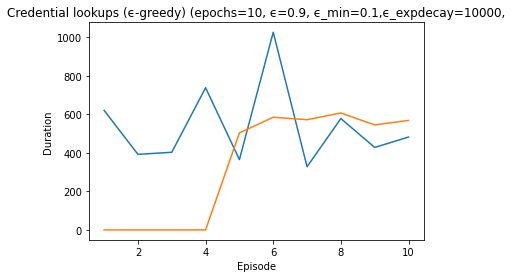

In [23]:
# Evaluate a random agent that opportunistically exploits
# credentials gathere in its local cache
credlookup_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=rca.CredentialCacheExploiter(),
    episode_count=10,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_exponential_decay=10000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="Credential lookups (ϵ-greedy)"
)

In [24]:
# Evaluate a Tabular Q-learning agent
tabularq_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=tqa.QTabularLearner(
        ep,
        gamma=0.015, learning_rate=0.01, exploit_percentile=100),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.01,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tabular Q-learning"
)

###### Tabular Q-learning
Learning with: episode_count=50,iteration_count=9000,ϵ=0.9,ϵ_min=0.01, ϵ_expdecay=5000,γ=0.015,learning_rate=0.01,Q%=100
  ## Episode: 1/50 'Tabular Q-learning' ϵ=0.9000, γ=0.015,learning_rate=0.01,Q%=100


Episode 1|Iteration 1048|reward: 6249.0|last_reward_at: 1048|Elapsed Time: 0:00:02||


  Episode 1 ended at t=1048 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 18/253 (0.07)
    explore-remote: 19/313 (0.06)
    explore-connect: 1/363 (0.00)
    exploit-local: 3/23 (0.12)
    exploit-remote: 1/44 (0.02)
    exploit-connect: 10/0 (1.00)
  exploit deflected to exploration: 96
  ## Episode: 2/50 'Tabular Q-learning' ϵ=0.7319, γ=0.015,learning_rate=0.01,Q%=100


Episode 2|Iteration 799|reward: 6227.0|last_reward_at:  799|Elapsed Time: 0:00:02||


  Episode 2 ended at t=799 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 16/175 (0.08)
    explore-remote: 14/222 (0.06)
    explore-connect: 0/263 (0.00)
    exploit-local: 4/13 (0.24)
    exploit-remote: 4/77 (0.05)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 142
  ## Episode: 3/50 'Tabular Q-learning' ϵ=0.6252, γ=0.015,learning_rate=0.01,Q%=100


Episode 3|Iteration 727|reward: 6239.0|last_reward_at:  727|Elapsed Time: 0:00:02||


  Episode 3 ended at t=727 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 16/200 (0.07)
    explore-remote: 20/219 (0.08)
    explore-connect: 0/215 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 0/42 (0.00)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 215
  ## Episode: 4/50 'Tabular Q-learning' ϵ=0.5420, γ=0.015,learning_rate=0.01,Q%=100


Episode 4|Iteration 212|reward: 6215.0|last_reward_at:  212|Elapsed Time: 0:00:00||


  Episode 4 ended at t=212 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/52 (0.19)
    explore-remote: 15/34 (0.31)
    explore-connect: 0/67 (0.00)
    exploit-local: 6/0 (1.00)
    exploit-remote: 2/13 (0.13)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 78
  ## Episode: 5/50 'Tabular Q-learning' ϵ=0.5199, γ=0.015,learning_rate=0.01,Q%=100


Episode 5|Iteration 495|reward: 6205.0|last_reward_at:  495|Elapsed Time: 0:00:01||


  Episode 5 ended at t=495 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/117 (0.07)
    explore-remote: 17/144 (0.11)
    explore-connect: 0/173 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 1/15 (0.06)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 222
  ## Episode: 6/50 'Tabular Q-learning' ϵ=0.4718, γ=0.015,learning_rate=0.01,Q%=100


Episode 6|Iteration 543|reward: 6239.0|last_reward_at:  543|Elapsed Time: 0:00:01||


  Episode 6 ended at t=543 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 15/129 (0.10)
    explore-remote: 17/165 (0.09)
    explore-connect: 0/164 (0.00)
    exploit-local: 5/0 (1.00)
    exploit-remote: 3/34 (0.08)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 259
  ## Episode: 7/50 'Tabular Q-learning' ϵ=0.4243, γ=0.015,learning_rate=0.01,Q%=100


Episode 7|Iteration 505|reward: 6237.0|last_reward_at:  505|Elapsed Time: 0:00:01||


  Episode 7 ended at t=505 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/118 (0.10)
    explore-remote: 18/159 (0.10)
    explore-connect: 0/167 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 2/10 (0.17)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 269
  ## Episode: 8/50 'Tabular Q-learning' ϵ=0.3845, γ=0.015,learning_rate=0.01,Q%=100


Episode 8|Iteration 883|reward: 6241.0|last_reward_at:  883|Elapsed Time: 0:00:02||


  Episode 8 ended at t=883 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 16/238 (0.06)
    explore-remote: 20/260 (0.07)
    explore-connect: 0/273 (0.00)
    exploit-local: 5/14 (0.26)
    exploit-remote: 0/46 (0.00)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 470
  ## Episode: 9/50 'Tabular Q-learning' ϵ=0.3239, γ=0.015,learning_rate=0.01,Q%=100


Episode 9|Iteration 613|reward: 6237.0|last_reward_at:  613|Elapsed Time: 0:00:01||


  Episode 9 ended at t=613 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 15/135 (0.10)
    explore-remote: 19/150 (0.11)
    explore-connect: 0/194 (0.00)
    exploit-local: 5/11 (0.31)
    exploit-remote: 1/72 (0.01)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 322
  ## Episode: 10/50 'Tabular Q-learning' ϵ=0.2877, γ=0.015,learning_rate=0.01,Q%=100


Episode 10|Iteration 436|reward: 6217.0|last_reward_at:  436|Elapsed Time: 0:00:01||


  Episode 10 ended at t=436 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/89 (0.11)
    explore-remote: 17/120 (0.12)
    explore-connect: 0/165 (0.00)
    exploit-local: 7/11 (0.39)
    exploit-remote: 1/4 (0.20)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 273
  ## Episode: 11/50 'Tabular Q-learning' ϵ=0.2645, γ=0.015,learning_rate=0.01,Q%=100


Episode 11|Iteration 400|reward: 6233.0|last_reward_at:  400|Elapsed Time: 0:00:01||


  Episode 11 ended at t=400 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/109 (0.09)
    explore-remote: 19/91 (0.17)
    explore-connect: 0/144 (0.00)
    exploit-local: 8/1 (0.89)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 280
  ## Episode: 12/50 'Tabular Q-learning' ϵ=0.2449, γ=0.015,learning_rate=0.01,Q%=100


Episode 12|Iteration 158|reward: 6199.0|last_reward_at:  158|Elapsed Time: 0:00:00||


  Episode 12 ended at t=158 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/26 (0.26)
    explore-remote: 14/33 (0.30)
    explore-connect: 0/52 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 2/4 (0.33)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 93
  ## Episode: 13/50 'Tabular Q-learning' ϵ=0.2376, γ=0.015,learning_rate=0.01,Q%=100


Episode 13|Iteration 327|reward: 6223.0|last_reward_at:  327|Elapsed Time: 0:00:01||


  Episode 13 ended at t=327 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/76 (0.13)
    explore-remote: 20/103 (0.16)
    explore-connect: 0/99 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 239
  ## Episode: 14/50 'Tabular Q-learning' ϵ=0.2232, γ=0.015,learning_rate=0.01,Q%=100


Episode 14|Iteration 199|reward: 6199.0|last_reward_at:  199|Elapsed Time: 0:00:00||


  Episode 14 ended at t=199 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/51 (0.15)
    explore-remote: 16/48 (0.25)
    explore-connect: 0/55 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 142
  ## Episode: 15/50 'Tabular Q-learning' ϵ=0.2149, γ=0.015,learning_rate=0.01,Q%=100


Episode 15|Iteration 491|reward: 6219.0|last_reward_at:  491|Elapsed Time: 0:00:01||


  Episode 15 ended at t=491 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/140 (0.07)
    explore-remote: 18/149 (0.11)
    explore-connect: 0/146 (0.00)
    exploit-local: 9/8 (0.53)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 358
  ## Episode: 16/50 'Tabular Q-learning' ϵ=0.1957, γ=0.015,learning_rate=0.01,Q%=100


Episode 16|Iteration 228|reward: 6201.0|last_reward_at:  228|Elapsed Time: 0:00:00||


  Episode 16 ended at t=228 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/46 (0.18)
    explore-remote: 16/53 (0.23)
    explore-connect: 0/83 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 167
  ## Episode: 17/50 'Tabular Q-learning' ϵ=0.1874, γ=0.015,learning_rate=0.01,Q%=100


Episode 17|Iteration 138|reward: 6173.0|last_reward_at:  138|Elapsed Time: 0:00:00||


  Episode 17 ended at t=138 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/23 (0.26)
    explore-remote: 13/25 (0.34)
    explore-connect: 0/51 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 100
  ## Episode: 18/50 'Tabular Q-learning' ϵ=0.1826, γ=0.015,learning_rate=0.01,Q%=100


Episode 18|Iteration 461|reward: 6203.0|last_reward_at:  461|Elapsed Time: 0:00:01||


  Episode 18 ended at t=461 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/100 (0.08)
    explore-remote: 16/135 (0.11)
    explore-connect: 0/181 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 358
  ## Episode: 19/50 'Tabular Q-learning' ϵ=0.1674, γ=0.015,learning_rate=0.01,Q%=100


Episode 19|Iteration 230|reward: 6193.0|last_reward_at:  230|Elapsed Time: 0:00:00||


  Episode 19 ended at t=230 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/44 (0.14)
    explore-remote: 14/61 (0.19)
    explore-connect: 0/82 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 178
  ## Episode: 20/50 'Tabular Q-learning' ϵ=0.1603, γ=0.015,learning_rate=0.01,Q%=100


Episode 20|Iteration 476|reward: 6217.0|last_reward_at:  476|Elapsed Time: 0:00:01||


  Episode 20 ended at t=476 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/112 (0.09)
    explore-remote: 16/151 (0.10)
    explore-connect: 0/155 (0.00)
    exploit-local: 8/4 (0.67)
    exploit-remote: 2/6 (0.25)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 376
  ## Episode: 21/50 'Tabular Q-learning' ϵ=0.1467, γ=0.015,learning_rate=0.01,Q%=100


Episode 21|Iteration 145|reward: 6209.0|last_reward_at:  145|Elapsed Time: 0:00:00||


  Episode 21 ended at t=145 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/21 (0.32)
    explore-remote: 15/26 (0.37)
    explore-connect: 0/44 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 2/8 (0.20)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 88
  ## Episode: 22/50 'Tabular Q-learning' ϵ=0.1428, γ=0.015,learning_rate=0.01,Q%=100


Episode 22|Iteration 324|reward: 6235.0|last_reward_at:  324|Elapsed Time: 0:00:01||


  Episode 22 ended at t=324 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/68 (0.14)
    explore-remote: 18/60 (0.23)
    explore-connect: 0/100 (0.00)
    exploit-local: 9/37 (0.20)
    exploit-remote: 2/8 (0.20)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 210
  ## Episode: 23/50 'Tabular Q-learning' ϵ=0.1344, γ=0.015,learning_rate=0.01,Q%=100


Episode 23|Iteration 496|reward: 6223.0|last_reward_at:  496|Elapsed Time: 0:00:01||


  Episode 23 ended at t=496 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/125 (0.06)
    explore-remote: 18/138 (0.12)
    explore-connect: 0/142 (0.00)
    exploit-local: 12/42 (0.22)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 369
  ## Episode: 24/50 'Tabular Q-learning' ϵ=0.1227, γ=0.015,learning_rate=0.01,Q%=100


Episode 24|Iteration 174|reward: 6187.0|last_reward_at:  174|Elapsed Time: 0:00:00||


  Episode 24 ended at t=174 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/34 (0.13)
    explore-remote: 15/34 (0.31)
    explore-connect: 0/64 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 134
  ## Episode: 25/50 'Tabular Q-learning' ϵ=0.1188, γ=0.015,learning_rate=0.01,Q%=100


Episode 25|Iteration 299|reward: 6197.0|last_reward_at:  299|Elapsed Time: 0:00:00||


  Episode 25 ended at t=299 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/64 (0.12)
    explore-remote: 16/94 (0.15)
    explore-connect: 0/97 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 241
  ## Episode: 26/50 'Tabular Q-learning' ϵ=0.1125, γ=0.015,learning_rate=0.01,Q%=100


Episode 26|Iteration 368|reward: 6197.0|last_reward_at:  368|Elapsed Time: 0:00:01||


  Episode 26 ended at t=368 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/77 (0.10)
    explore-remote: 15/113 (0.12)
    explore-connect: 0/126 (0.00)
    exploit-local: 8/9 (0.47)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 303
  ## Episode: 27/50 'Tabular Q-learning' ϵ=0.1052, γ=0.015,learning_rate=0.01,Q%=100


Episode 27|Iteration 195|reward: 6195.0|last_reward_at:  195|Elapsed Time: 0:00:00||


  Episode 27 ended at t=195 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/29 (0.17)
    explore-remote: 17/31 (0.35)
    explore-connect: 0/52 (0.00)
    exploit-local: 10/39 (0.20)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 116
  ## Episode: 28/50 'Tabular Q-learning' ϵ=0.1016, γ=0.015,learning_rate=0.01,Q%=100


Episode 28|Iteration 207|reward: 6201.0|last_reward_at:  207|Elapsed Time: 0:00:00||


  Episode 28 ended at t=207 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/42 (0.11)
    explore-remote: 18/33 (0.35)
    explore-connect: 0/60 (0.00)
    exploit-local: 11/27 (0.29)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 135
  ## Episode: 29/50 'Tabular Q-learning' ϵ=0.0979, γ=0.015,learning_rate=0.01,Q%=100


Episode 29|Iteration 491|reward: 6237.0|last_reward_at:  491|Elapsed Time: 0:00:01||


  Episode 29 ended at t=491 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/105 (0.11)
    explore-remote: 20/167 (0.11)
    explore-connect: 0/168 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 420
  ## Episode: 30/50 'Tabular Q-learning' ϵ=0.0897, γ=0.015,learning_rate=0.01,Q%=100


Episode 30|Iteration 119|reward: 6165.0|last_reward_at:  119|Elapsed Time: 0:00:00||


  Episode 30 ended at t=119 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/18 (0.22)
    explore-remote: 11/25 (0.31)
    explore-connect: 0/39 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 88
  ## Episode: 31/50 'Tabular Q-learning' ϵ=0.0878, γ=0.015,learning_rate=0.01,Q%=100


Episode 31|Iteration 232|reward: 6175.0|last_reward_at:  232|Elapsed Time: 0:00:00||


  Episode 31 ended at t=232 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/48 (0.09)
    explore-remote: 14/63 (0.18)
    explore-connect: 0/81 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 184
  ## Episode: 32/50 'Tabular Q-learning' ϵ=0.0843, γ=0.015,learning_rate=0.01,Q%=100


Episode 32|Iteration 187|reward: 6209.0|last_reward_at:  187|Elapsed Time: 0:00:00||


  Episode 32 ended at t=187 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/34 (0.21)
    explore-remote: 18/38 (0.32)
    explore-connect: 0/68 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 154
  ## Episode: 33/50 'Tabular Q-learning' ϵ=0.0815, γ=0.015,learning_rate=0.01,Q%=100


Episode 33|Iteration 184|reward: 6197.0|last_reward_at:  184|Elapsed Time: 0:00:00||


  Episode 33 ended at t=184 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/31 (0.18)
    explore-remote: 18/43 (0.30)
    explore-connect: 0/63 (0.00)
    exploit-local: 9/2 (0.82)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 144
  ## Episode: 34/50 'Tabular Q-learning' ϵ=0.0790, γ=0.015,learning_rate=0.01,Q%=100


Episode 34|Iteration 439|reward: 6233.0|last_reward_at:  439|Elapsed Time: 0:00:01||


  Episode 34 ended at t=439 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/106 (0.09)
    explore-remote: 20/130 (0.13)
    explore-connect: 0/137 (0.00)
    exploit-local: 9/15 (0.38)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 366
  ## Episode: 35/50 'Tabular Q-learning' ϵ=0.0732, γ=0.015,learning_rate=0.01,Q%=100


Episode 35|Iteration 636|reward: 6229.0|last_reward_at:  636|Elapsed Time: 0:00:01||


  Episode 35 ended at t=636 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/130 (0.07)
    explore-remote: 20/238 (0.08)
    explore-connect: 0/212 (0.00)
    exploit-local: 9/6 (0.60)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 564
  ## Episode: 36/50 'Tabular Q-learning' ϵ=0.0656, γ=0.015,learning_rate=0.01,Q%=100


Episode 36|Iteration 111|reward: 6155.0|last_reward_at:  111|Elapsed Time: 0:00:00||


  Episode 36 ended at t=111 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/24 (0.25)
    explore-remote: 11/22 (0.33)
    explore-connect: 0/29 (0.00)
    exploit-local: 6/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 87
  ## Episode: 37/50 'Tabular Q-learning' ϵ=0.0644, γ=0.015,learning_rate=0.01,Q%=100


Episode 37|Iteration 274|reward: 6209.0|last_reward_at:  274|Elapsed Time: 0:00:00||


  Episode 37 ended at t=274 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 14/74 (0.16)
    explore-remote: 16/69 (0.19)
    explore-connect: 0/86 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 240
  ## Episode: 38/50 'Tabular Q-learning' ϵ=0.0615, γ=0.015,learning_rate=0.01,Q%=100


Episode 38|Iteration 229|reward: 6205.0|last_reward_at:  229|Elapsed Time: 0:00:00||


  Episode 38 ended at t=229 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/52 (0.17)
    explore-remote: 18/58 (0.24)
    explore-connect: 0/73 (0.00)
    exploit-local: 6/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 193
  ## Episode: 39/50 'Tabular Q-learning' ϵ=0.0592, γ=0.015,learning_rate=0.01,Q%=100


Episode 39|Iteration 385|reward: 6205.0|last_reward_at:  385|Elapsed Time: 0:00:01||


  Episode 39 ended at t=385 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/104 (0.10)
    explore-remote: 16/102 (0.14)
    explore-connect: 0/134 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 352
  ## Episode: 40/50 'Tabular Q-learning' ϵ=0.0555, γ=0.015,learning_rate=0.01,Q%=100


Episode 40|Iteration 299|reward: 6209.0|last_reward_at:  299|Elapsed Time: 0:00:00||


  Episode 40 ended at t=299 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/70 (0.11)
    explore-remote: 17/78 (0.18)
    explore-connect: 0/94 (0.00)
    exploit-local: 9/11 (0.45)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 256
  ## Episode: 41/50 'Tabular Q-learning' ϵ=0.0529, γ=0.015,learning_rate=0.01,Q%=100


Episode 41|Iteration 604|reward: 6225.0|last_reward_at:  604|Elapsed Time: 0:00:01||


  Episode 41 ended at t=604 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/139 (0.06)
    explore-remote: 18/180 (0.09)
    explore-connect: 0/183 (0.00)
    exploit-local: 10/39 (0.20)
    exploit-remote: 1/14 (0.07)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 501
  ## Episode: 42/50 'Tabular Q-learning' ϵ=0.0480, γ=0.015,learning_rate=0.01,Q%=100


Episode 42|Iteration 200|reward: 6177.0|last_reward_at:  200|Elapsed Time: 0:00:00||


  Episode 42 ended at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/38 (0.17)
    explore-remote: 14/47 (0.23)
    explore-connect: 0/64 (0.00)
    exploit-local: 8/10 (0.44)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 162
  ## Episode: 43/50 'Tabular Q-learning' ϵ=0.0465, γ=0.015,learning_rate=0.01,Q%=100


Episode 43|Iteration 250|reward: 6223.0|last_reward_at:  250|Elapsed Time: 0:00:00||


  Episode 43 ended at t=250 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/52 (0.17)
    explore-remote: 19/65 (0.23)
    explore-connect: 0/84 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 224
  ## Episode: 44/50 'Tabular Q-learning' ϵ=0.0447, γ=0.015,learning_rate=0.01,Q%=100


Episode 44|Iteration 247|reward: 6203.0|last_reward_at:  247|Elapsed Time: 0:00:00||


  Episode 44 ended at t=247 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/48 (0.14)
    explore-remote: 18/57 (0.24)
    explore-connect: 0/96 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 218
  ## Episode: 45/50 'Tabular Q-learning' ϵ=0.0431, γ=0.015,learning_rate=0.01,Q%=100


Episode 45|Iteration 423|reward: 6217.0|last_reward_at:  423|Elapsed Time: 0:00:01||


  Episode 45 ended at t=423 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/92 (0.08)
    explore-remote: 20/140 (0.12)
    explore-connect: 0/143 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 379
  ## Episode: 46/50 'Tabular Q-learning' ϵ=0.0404, γ=0.015,learning_rate=0.01,Q%=100


Episode 46|Iteration 137|reward: 6177.0|last_reward_at:  137|Elapsed Time: 0:00:00||


  Episode 46 ended at t=137 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/22 (0.21)
    explore-remote: 12/26 (0.32)
    explore-connect: 0/39 (0.00)
    exploit-local: 10/11 (0.48)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 99
  ## Episode: 47/50 'Tabular Q-learning' ϵ=0.0396, γ=0.015,learning_rate=0.01,Q%=100


Episode 47|Iteration 133|reward: 6177.0|last_reward_at:  133|Elapsed Time: 0:00:00||


  Episode 47 ended at t=133 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/17 (0.23)
    explore-remote: 14/26 (0.35)
    explore-connect: 0/33 (0.00)
    exploit-local: 9/16 (0.36)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 91
  ## Episode: 48/50 'Tabular Q-learning' ϵ=0.0388, γ=0.015,learning_rate=0.01,Q%=100


Episode 48|Iteration 547|reward: 6217.0|last_reward_at:  547|Elapsed Time: 0:00:01||


  Episode 48 ended at t=547 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/123 (0.08)
    explore-remote: 13/150 (0.08)
    explore-connect: 0/180 (0.00)
    exploit-local: 9/17 (0.35)
    exploit-remote: 4/30 (0.12)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 457
  ## Episode: 49/50 'Tabular Q-learning' ϵ=0.0358, γ=0.015,learning_rate=0.01,Q%=100


Episode 49|Iteration 249|reward: 6211.0|last_reward_at:  249|Elapsed Time: 0:00:00||


  Episode 49 ended at t=249 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/56 (0.12)
    explore-remote: 16/62 (0.21)
    explore-connect: 0/72 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 3/12 (0.20)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 204
  ## Episode: 50/50 'Tabular Q-learning' ϵ=0.0346, γ=0.015,learning_rate=0.01,Q%=100


Episode 50|Iteration 454|reward: 6237.0|last_reward_at:  454|Elapsed Time: 0:00:01||


  Episode 50 ended at t=454 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/101 (0.10)
    explore-remote: 17/126 (0.12)
    explore-connect: 0/121 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 3/55 (0.05)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 364
simulation ended


###### Exploiting Q-matrix
Learning with: episode_count=5,iteration_count=9000,ϵ=0.0,ϵ_min=0.0, γ=0.0,learning_rate=0.0,Q%=90
  ## Episode: 1/5 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 1|Iteration 1281|reward: 6239.0|last_reward_at: 1281|Elapsed Time: 0:00:04||


  Episode 1 ended at t=1281 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/168 (0.06)
    explore-remote: 14/235 (0.06)
    explore-connect: 0/219 (0.00)
    exploit-local: 10/402 (0.02)
    exploit-remote: 6/206 (0.03)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 646
  ## Episode: 2/5 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 2|Iteration 1159|reward: 6245.0|last_reward_at: 1159|Elapsed Time: 0:00:03||


  Episode 2 ended at t=1159 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/165 (0.07)
    explore-remote: 18/186 (0.09)
    explore-connect: 0/224 (0.00)
    exploit-local: 8/338 (0.02)
    exploit-remote: 2/194 (0.01)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 606
  ## Episode: 3/5 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 3|Iteration 1924|reward: 6249.0|last_reward_at: 1924|Elapsed Time: 0:00:05||


  Episode 3 ended at t=1924 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/266 (0.04)
    explore-remote: 16/371 (0.04)
    explore-connect: 0/365 (0.00)
    exploit-local: 9/747 (0.01)
    exploit-remote: 4/123 (0.03)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 1030
  ## Episode: 4/5 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 4|Iteration 2122|reward: 6249.0|last_reward_at: 2122|Elapsed Time: 0:00:06||


  Episode 4 ended at t=2122 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 15/281 (0.05)
    explore-remote: 16/326 (0.05)
    explore-connect: 0/415 (0.00)
    exploit-local: 6/725 (0.01)
    exploit-remote: 4/323 (0.01)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 1053
  ## Episode: 5/5 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 5|Iteration 750|reward: 6235.0|last_reward_at:  750|Elapsed Time: 0:00:02||


  Episode 5 ended at t=750 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/92 (0.12)
    explore-remote: 16/114 (0.12)
    explore-connect: 0/125 (0.00)
    exploit-local: 8/276 (0.03)
    exploit-remote: 3/93 (0.03)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 359
simulation ended


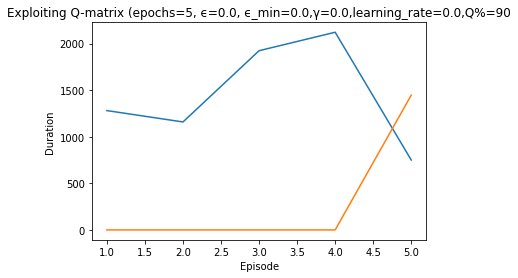

In [25]:
# Evaluate an agent that exploits the Q-table learnt above
tabularq_exploit_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=tqa.QTabularLearner(
        ep,
        trained=tabularq_run['learner'],
        gamma=0.0,
        learning_rate=0.0,
        exploit_percentile=90),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    render=False,
    verbosity=Verbosity.Quiet,
    title="Exploiting Q-matrix"
)

In [33]:
# Evaluate the Deep Q-learning agent
dql_run = learner.epsilon_greedy_search(
    cyberbattle_gym_env=gym_env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="DQL"
)

###### DQL
Learning with: episode_count=50,iteration_count=9000,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/50 'DQL' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 1098|reward: 6245.0|last_reward_at: 1098|Elapsed Time: 0:00:12||


  Episode 1 ended at t=1098 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/206 (0.04)
    explore-remote: 18/338 (0.05)
    explore-connect: 3/338 (0.01)
    exploit-local: 12/97 (0.11)
    exploit-remote: 1/17 (0.06)
    exploit-connect: 8/52 (0.13)
  exploit deflected to exploration: 2
  ## Episode: 2/50 'DQL' ϵ=0.7424, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 442|reward: 6247.0|last_reward_at:  442|Elapsed Time: 0:00:09||


  Episode 2 ended at t=442 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/84 (0.03)
    explore-remote: 13/118 (0.10)
    explore-connect: 1/115 (0.01)
    exploit-local: 18/18 (0.50)
    exploit-remote: 6/20 (0.23)
    exploit-connect: 10/36 (0.22)
  exploit deflected to exploration: 7
  ## Episode: 3/50 'DQL' ϵ=0.6880, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 208|reward: 6217.0|last_reward_at:  208|Elapsed Time: 0:00:04||


  Episode 3 ended at t=208 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/32 (0.06)
    explore-remote: 11/34 (0.24)
    explore-connect: 1/63 (0.02)
    exploit-local: 19/4 (0.83)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 10/26 (0.28)
  exploit deflected to exploration: 1
  ## Episode: 4/50 'DQL' ϵ=0.6641, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 164|reward: 6213.0|last_reward_at:  164|Elapsed Time: 0:00:03||


  Episode 4 ended at t=164 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/28 (0.07)
    explore-remote: 14/30 (0.32)
    explore-connect: 0/38 (0.00)
    exploit-local: 19/1 (0.95)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 11/19 (0.37)
  exploit deflected to exploration: 1
  ## Episode: 5/50 'DQL' ϵ=0.6459, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 111|reward: 6217.0|last_reward_at:  111|Elapsed Time: 0:00:02||


  Episode 5 ended at t=111 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/16 (0.16)
    explore-remote: 13/14 (0.48)
    explore-connect: 1/26 (0.04)
    exploit-local: 18/2 (0.90)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 10/8 (0.56)
  exploit deflected to exploration: 2
  ## Episode: 6/50 'DQL' ϵ=0.6339, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 6|Iteration 228|reward: 6215.0|last_reward_at:  228|Elapsed Time: 0:00:04||


  Episode 6 ended at t=228 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/43 (0.04)
    explore-remote: 14/39 (0.26)
    explore-connect: 0/52 (0.00)
    exploit-local: 17/1 (0.94)
    exploit-remote: 2/4 (0.33)
    exploit-connect: 11/43 (0.20)
  exploit deflected to exploration: 0
  ## Episode: 7/50 'DQL' ϵ=0.6101, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 7|Iteration 144|reward: 6159.0|last_reward_at:  144|Elapsed Time: 0:00:03||


  Episode 7 ended at t=144 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/14 (0.18)
    explore-remote: 6/37 (0.14)
    explore-connect: 0/34 (0.00)
    exploit-local: 13/2 (0.87)
    exploit-remote: 2/18 (0.10)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 8/50 'DQL' ϵ=0.5956, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 8|Iteration 198|reward: 6191.0|last_reward_at:  198|Elapsed Time: 0:00:04||


  Episode 8 ended at t=198 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/28 (0.12)
    explore-remote: 9/34 (0.21)
    explore-connect: 0/30 (0.00)
    exploit-local: 13/0 (1.00)
    exploit-remote: 6/59 (0.09)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 4
  ## Episode: 9/50 'DQL' ϵ=0.5764, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 9|Iteration 105|reward: 6183.0|last_reward_at:  105|Elapsed Time: 0:00:02||


  Episode 9 ended at t=105 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/15 (0.12)
    explore-remote: 7/18 (0.28)
    explore-connect: 0/22 (0.00)
    exploit-local: 15/0 (1.00)
    exploit-remote: 4/10 (0.29)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 10/50 'DQL' ϵ=0.5665, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 10|Iteration 46|reward: 6141.0|last_reward_at:   46|Elapsed Time: 0:00:01||


  Episode 10 ended at t=46 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/5 (0.38)
    explore-remote: 3/2 (0.60)
    explore-connect: 0/6 (0.00)
    exploit-local: 13/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 11/2 (0.85)
  exploit deflected to exploration: 0
  ## Episode: 11/50 'DQL' ϵ=0.5622, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 11|Iteration 182|reward: 6185.0|last_reward_at:  182|Elapsed Time: 0:00:05||


  Episode 11 ended at t=182 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/32 (0.06)
    explore-remote: 11/31 (0.26)
    explore-connect: 0/33 (0.00)
    exploit-local: 13/0 (1.00)
    exploit-remote: 5/44 (0.10)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 7
  ## Episode: 12/50 'DQL' ϵ=0.5457, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 12|Iteration 56|reward: 6151.0|last_reward_at:   56|Elapsed Time: 0:00:01||


  Episode 12 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/10 (0.00)
    explore-remote: 7/7 (0.50)
    explore-connect: 0/7 (0.00)
    exploit-local: 14/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 13/50 'DQL' ϵ=0.5407, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 13|Iteration 64|reward: 6159.0|last_reward_at:   64|Elapsed Time: 0:00:01||


  Episode 13 ended at t=64 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/8 (0.00)
    explore-remote: 7/4 (0.64)
    explore-connect: 0/12 (0.00)
    exploit-local: 15/1 (0.94)
    exploit-remote: 2/0 (1.00)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 14/50 'DQL' ϵ=0.5351, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 14|Iteration 60|reward: 6157.0|last_reward_at:   60|Elapsed Time: 0:00:01||


  Episode 14 ended at t=60 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 7/1 (0.88)
    explore-connect: 0/12 (0.00)
    exploit-local: 14/0 (1.00)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 15/50 'DQL' ϵ=0.5299, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 15|Iteration 73|reward: 6167.0|last_reward_at:   73|Elapsed Time: 0:00:01||


  Episode 15 ended at t=73 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/11 (0.15)
    explore-remote: 4/8 (0.33)
    explore-connect: 0/16 (0.00)
    exploit-local: 17/0 (1.00)
    exploit-remote: 2/1 (0.67)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 16/50 'DQL' ϵ=0.5237, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 16|Iteration 327|reward: 6165.0|last_reward_at:  327|Elapsed Time: 0:00:08||


  Episode 16 ended at t=327 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/37 (0.10)
    explore-remote: 7/81 (0.08)
    explore-connect: 0/59 (0.00)
    exploit-local: 11/2 (0.85)
    exploit-remote: 4/72 (0.05)
    exploit-connect: 11/39 (0.22)
  exploit deflected to exploration: 22
  ## Episode: 17/50 'DQL' ϵ=0.4969, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 17|Iteration 59|reward: 6129.0|last_reward_at:   59|Elapsed Time: 0:00:01||


  Episode 17 ended at t=59 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 6/4 (0.60)
    explore-connect: 0/12 (0.00)
    exploit-local: 10/3 (0.77)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 2
  ## Episode: 18/50 'DQL' ϵ=0.4922, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 18|Iteration 124|reward: 6171.0|last_reward_at:  124|Elapsed Time: 0:00:03||


  Episode 18 ended at t=124 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/12 (0.20)
    explore-remote: 4/15 (0.21)
    explore-connect: 0/26 (0.00)
    exploit-local: 11/1 (0.92)
    exploit-remote: 9/32 (0.22)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 11
  ## Episode: 19/50 'DQL' ϵ=0.4826, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 19|Iteration 45|reward: 6115.0|last_reward_at:   45|Elapsed Time: 0:00:00||


  Episode 19 ended at t=45 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 2/4 (0.33)
    explore-connect: 0/10 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 20/50 'DQL' ϵ=0.4792, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 20|Iteration 96|reward: 6157.0|last_reward_at:   96|Elapsed Time: 0:00:02||


  Episode 20 ended at t=96 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/10 (0.23)
    explore-remote: 4/12 (0.25)
    explore-connect: 1/13 (0.07)
    exploit-local: 12/0 (1.00)
    exploit-remote: 4/24 (0.14)
    exploit-connect: 10/3 (0.77)
  exploit deflected to exploration: 0
  ## Episode: 21/50 'DQL' ϵ=0.4720, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 21|Iteration 44|reward: 6131.0|last_reward_at:   44|Elapsed Time: 0:00:00||


  Episode 21 ended at t=44 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 8/3 (0.73)
    explore-connect: 0/7 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 22/50 'DQL' ϵ=0.4687, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 22|Iteration 33|reward: 6113.0|last_reward_at:   33|Elapsed Time: 0:00:00||


  Episode 22 ended at t=33 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 3/2 (0.60)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 23/50 'DQL' ϵ=0.4663, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 23|Iteration 72|reward: 6155.0|last_reward_at:   72|Elapsed Time: 0:00:01||


  Episode 23 ended at t=72 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 6/4 (0.60)
    explore-connect: 1/15 (0.06)
    exploit-local: 12/0 (1.00)
    exploit-remote: 5/7 (0.42)
    exploit-connect: 10/3 (0.77)
  exploit deflected to exploration: 0
  ## Episode: 24/50 'DQL' ϵ=0.4610, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 24|Iteration 53|reward: 6143.0|last_reward_at:   53|Elapsed Time: 0:00:01||


  Episode 24 ended at t=53 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/4 (0.43)
    explore-remote: 7/5 (0.58)
    explore-connect: 0/11 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 25/50 'DQL' ϵ=0.4572, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 25|Iteration 44|reward: 6113.0|last_reward_at:   44|Elapsed Time: 0:00:01||


  Episode 25 ended at t=44 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 2/7 (0.22)
    explore-connect: 0/7 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/2 (0.85)
  exploit deflected to exploration: 0
  ## Episode: 26/50 'DQL' ϵ=0.4541, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 26|Iteration 36|reward: 6111.0|last_reward_at:   36|Elapsed Time: 0:00:00||


  Episode 26 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/3 (0.40)
    explore-remote: 0/1 (0.00)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/2 (0.85)
  exploit deflected to exploration: 0
  ## Episode: 27/50 'DQL' ϵ=0.4516, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 27|Iteration 114|reward: 6145.0|last_reward_at:  114|Elapsed Time: 0:00:03||


  Episode 27 ended at t=114 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/13 (0.13)
    explore-remote: 3/12 (0.20)
    explore-connect: 1/19 (0.05)
    exploit-local: 11/0 (1.00)
    exploit-remote: 5/28 (0.15)
    exploit-connect: 10/10 (0.50)
  exploit deflected to exploration: 0
  ## Episode: 28/50 'DQL' ϵ=0.4436, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 28|Iteration 55|reward: 6131.0|last_reward_at:   55|Elapsed Time: 0:00:01||


  Episode 28 ended at t=55 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 5/4 (0.56)
    explore-connect: 0/8 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 2/6 (0.25)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 2
  ## Episode: 29/50 'DQL' ϵ=0.4399, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 29|Iteration 36|reward: 6117.0|last_reward_at:   36|Elapsed Time: 0:00:00||


  Episode 29 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 4/2 (0.67)
    explore-connect: 0/3 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 30/50 'DQL' ϵ=0.4374, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 30|Iteration 37|reward: 6125.0|last_reward_at:   37|Elapsed Time: 0:00:01||


  Episode 30 ended at t=37 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 5/1 (0.83)
    explore-connect: 0/8 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 31/50 'DQL' ϵ=0.4350, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 31|Iteration 51|reward: 6137.0|last_reward_at:   51|Elapsed Time: 0:00:01||


  Episode 31 ended at t=51 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 7/9 (0.44)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 1/2 (0.33)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 32/50 'DQL' ϵ=0.4316, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 32|Iteration 51|reward: 6131.0|last_reward_at:   51|Elapsed Time: 0:00:01||


  Episode 32 ended at t=51 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 6/2 (0.75)
    explore-connect: 0/9 (0.00)
    exploit-local: 12/0 (1.00)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 11/2 (0.85)
  exploit deflected to exploration: 0
  ## Episode: 33/50 'DQL' ϵ=0.4282, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 33|Iteration 54|reward: 6131.0|last_reward_at:   54|Elapsed Time: 0:00:01||


  Episode 33 ended at t=54 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 2/3 (0.40)
    explore-connect: 0/10 (0.00)
    exploit-local: 13/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/5 (0.69)
  exploit deflected to exploration: 0
  ## Episode: 34/50 'DQL' ϵ=0.4247, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 34|Iteration 50|reward: 6125.0|last_reward_at:   50|Elapsed Time: 0:00:01||


  Episode 34 ended at t=50 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 7/6 (0.54)
    explore-connect: 0/9 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/3 (0.79)
  exploit deflected to exploration: 0
  ## Episode: 35/50 'DQL' ϵ=0.4214, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 35|Iteration 51|reward: 6137.0|last_reward_at:   51|Elapsed Time: 0:00:01||


  Episode 35 ended at t=51 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 7/5 (0.58)
    explore-connect: 0/13 (0.00)
    exploit-local: 12/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 4
  ## Episode: 36/50 'DQL' ϵ=0.4182, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 36|Iteration 107|reward: 6151.0|last_reward_at:  107|Elapsed Time: 0:00:02||


  Episode 36 ended at t=107 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 7/15 (0.32)
    explore-connect: 0/17 (0.00)
    exploit-local: 12/1 (0.92)
    exploit-remote: 5/22 (0.19)
    exploit-connect: 11/5 (0.69)
  exploit deflected to exploration: 0
  ## Episode: 37/50 'DQL' ϵ=0.4114, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 37|Iteration 157|reward: 6133.0|last_reward_at:  157|Elapsed Time: 0:00:03||


  Episode 37 ended at t=157 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/18 (0.10)
    explore-remote: 4/18 (0.18)
    explore-connect: 0/18 (0.00)
    exploit-local: 11/4 (0.73)
    exploit-remote: 2/65 (0.03)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 38/50 'DQL' ϵ=0.4018, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 38|Iteration 43|reward: 6129.0|last_reward_at:   43|Elapsed Time: 0:00:01||


  Episode 38 ended at t=43 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 5/4 (0.56)
    explore-connect: 0/2 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 39/50 'DQL' ϵ=0.3992, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 39|Iteration 38|reward: 6113.0|last_reward_at:   38|Elapsed Time: 0:00:00||


  Episode 39 ended at t=38 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 3/2 (0.60)
    explore-connect: 1/6 (0.14)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 10/3 (0.77)
  exploit deflected to exploration: 0
  ## Episode: 40/50 'DQL' ϵ=0.3970, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 40|Iteration 42|reward: 6125.0|last_reward_at:   42|Elapsed Time: 0:00:00||


  Episode 40 ended at t=42 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/3 (0.40)
    explore-remote: 4/2 (0.67)
    explore-connect: 0/8 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/2 (0.85)
  exploit deflected to exploration: 0
  ## Episode: 41/50 'DQL' ϵ=0.3945, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 41|Iteration 38|reward: 6121.0|last_reward_at:   38|Elapsed Time: 0:00:00||


  Episode 41 ended at t=38 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 4/1 (0.80)
    explore-connect: 0/9 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 42/50 'DQL' ϵ=0.3923, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 42|Iteration 31|reward: 6125.0|last_reward_at:   31|Elapsed Time: 0:00:00||


  Episode 42 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 4/0 (1.00)
    explore-connect: 0/2 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 43/50 'DQL' ϵ=0.3904, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 43|Iteration 48|reward: 6125.0|last_reward_at:   48|Elapsed Time: 0:00:01||


  Episode 43 ended at t=48 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 6/1 (0.86)
    explore-connect: 0/7 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/6 (0.65)
  exploit deflected to exploration: 0
  ## Episode: 44/50 'DQL' ϵ=0.3877, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 44|Iteration 32|reward: 6099.0|last_reward_at:   32|Elapsed Time: 0:00:00||


  Episode 44 ended at t=32 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 0/3 (0.00)
    explore-connect: 0/3 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 45/50 'DQL' ϵ=0.3858, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 45|Iteration 40|reward: 6123.0|last_reward_at:   40|Elapsed Time: 0:00:00||


  Episode 45 ended at t=40 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 6/2 (0.75)
    explore-connect: 0/7 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 46/50 'DQL' ϵ=0.3836, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 46|Iteration 37|reward: 6117.0|last_reward_at:   37|Elapsed Time: 0:00:00||


  Episode 46 ended at t=37 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 4/1 (0.80)
    explore-connect: 0/5 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 47/50 'DQL' ϵ=0.3815, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 47|Iteration 39|reward: 6129.0|last_reward_at:   39|Elapsed Time: 0:00:00||


  Episode 47 ended at t=39 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 5/1 (0.83)
    explore-connect: 0/4 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 48/50 'DQL' ϵ=0.3793, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 48|Iteration 40|reward: 6111.0|last_reward_at:   40|Elapsed Time: 0:00:00||


  Episode 48 ended at t=40 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 3/0 (1.00)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 49/50 'DQL' ϵ=0.3771, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 49|Iteration 31|reward: 6117.0|last_reward_at:   31|Elapsed Time: 0:00:00||


  Episode 49 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/0 (1.00)
    explore-remote: 2/1 (0.67)
    explore-connect: 0/4 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 50/50 'DQL' ϵ=0.3753, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 50|Iteration 38|reward: 6115.0|last_reward_at:   38|Elapsed Time: 0:00:00||


  Episode 50 ended at t=38 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 4/1 (0.80)
    explore-connect: 0/8 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
simulation ended


In [34]:
# Evaluate an agent that exploits the Q-function learnt above
dql_exploit_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=dql_run['learner'],
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    epsilon_minimum=0.00,
    render=False,
    plot_episodes_length=False,
    verbosity=Verbosity.Quiet,
    title="Exploiting DQL"
)

###### Exploiting DQL
Learning with: episode_count=5,iteration_count=9000,ϵ=0.0,ϵ_min=0.0, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/5 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 26|reward: 6099.0|last_reward_at:   26|Elapsed Time: 0:00:00||


  Episode 1 ended at t=26 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/0 (NaN)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 2/5 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 23|reward: 6099.0|last_reward_at:   23|Elapsed Time: 0:00:00||


  Episode 2 ended at t=23 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/0 (NaN)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 3/5 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 23|reward: 6099.0|last_reward_at:   23|Elapsed Time: 0:00:00||


  Episode 3 ended at t=23 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/0 (NaN)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 4/5 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 22|reward: 6099.0|last_reward_at:   22|Elapsed Time: 0:00:00||


  Episode 4 ended at t=22 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/0 (NaN)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 5/5 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 23|reward: 6099.0|last_reward_at:   23|Elapsed Time: 0:00:00||


  Episode 5 ended at t=23 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/0 (NaN)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
simulation ended


In [27]:
# Evaluate the random agent
random_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=learner.RandomPolicy(),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=1.0,  # purely random
    render=False,
    verbosity=Verbosity.Quiet,
    plot_episodes_length=False,
    title="Random search"
)

###### Random search
Learning with: episode_count=5,iteration_count=9000,ϵ=1.0,ϵ_min=0.0, 
  ## Episode: 1/5 'Random search' ϵ=1.0000, 


Episode 1|Iteration 8172|reward: 6257.0|last_reward_at: 8172|Elapsed Time: 0:00:16||


  Episode 1 ended at t=8172 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/2316 (0.01)
    explore-remote: 20/2914 (0.01)
    explore-connect: 11/2890 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 2/5 'Random search' ϵ=1.0000, 


Episode 2|Iteration 9000|reward:  890.0|last_reward_at: 8989|Elapsed Time: 0:00:17||


  Episode 2 stopped at t=9000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 15/2538 (0.01)
    explore-remote: 16/3212 (0.00)
    explore-connect: 7/3212 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 3/5 'Random search' ϵ=1.0000, 


Episode 3|Iteration 9000|reward: 1259.0|last_reward_at: 7812|Elapsed Time: 0:00:17||


  Episode 3 stopped at t=9000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/2465 (0.01)
    explore-remote: 20/3174 (0.01)
    explore-connect: 10/3310 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 4/5 'Random search' ϵ=1.0000, 


Episode 4|Iteration 7855|reward: 6259.0|last_reward_at: 7855|Elapsed Time: 0:00:16||


  Episode 4 ended at t=7855 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 21/2192 (0.01)
    explore-remote: 20/2801 (0.01)
    explore-connect: 11/2810 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 5/5 'Random search' ϵ=1.0000, 


Episode 5|Iteration 9000|reward:  892.0|last_reward_at: 6031|Elapsed Time: 0:00:14||


  Episode 5 stopped at t=9000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 15/2443 (0.01)
    explore-remote: 16/3161 (0.01)
    explore-connect: 7/3358 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
simulation ended


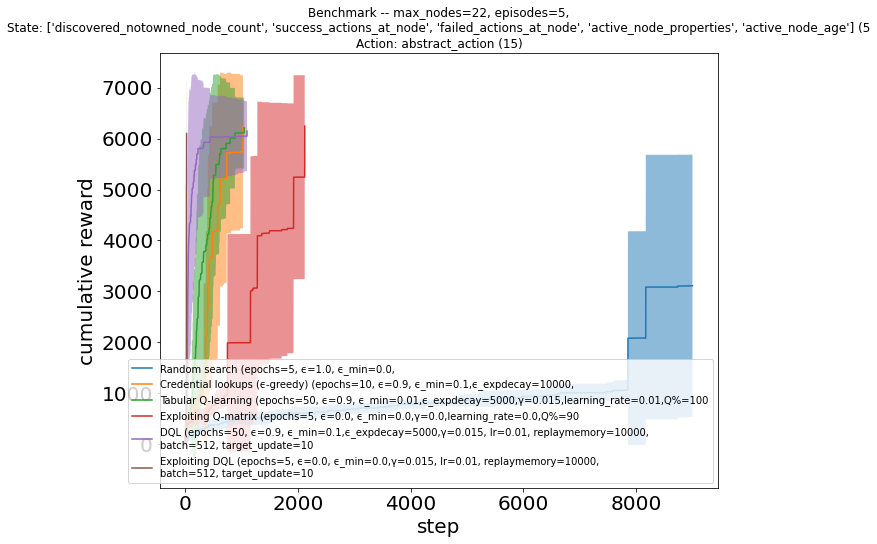

In [35]:
# Compare and plot results for all the agents
all_runs = [
    random_run,
    credlookup_run,
    tabularq_run,
    tabularq_exploit_run,
    dql_run,
    dql_exploit_run
]

# Plot averaged cumulative rewards for DQL vs Random vs DQL-Exploit
themodel = dqla.CyberBattleStateActionModel(ep)
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f'Benchmark -- max_nodes={ep.maximum_node_count}, episodes={eval_episode_count},\n'
    f'State: {[f.name() for f in themodel.state_space.feature_selection]} '
    f'({len(themodel.state_space.feature_selection)}\n'
    f"Action: abstract_action ({themodel.action_space.flat_size()})")

[6249.0, 6247.0, 6233.0, 6245.0, 6231.0, 6243.0, 6243.0, 6243.0, 6245.0, 6245.0]
[6257.0, 890.0, 1259.0, 6259.0, 892.0]
[6249.0, 6227.0, 6239.0, 6215.0, 6205.0, 6239.0, 6237.0, 6241.0, 6237.0, 6217.0, 6233.0, 6199.0, 6223.0, 6199.0, 6219.0, 6201.0, 6173.0, 6203.0, 6193.0, 6217.0, 6209.0, 6235.0, 6223.0, 6187.0, 6197.0, 6197.0, 6195.0, 6201.0, 6237.0, 6165.0, 6175.0, 6209.0, 6197.0, 6233.0, 6229.0, 6155.0, 6209.0, 6205.0, 6205.0, 6209.0, 6225.0, 6177.0, 6223.0, 6203.0, 6217.0, 6177.0, 6177.0, 6217.0, 6211.0, 6237.0]
[6239.0, 6245.0, 6249.0, 6249.0, 6235.0]
[6243.0, 6249.0, 6251.0, 6249.0, 6247.0, 6241.0, 6247.0, 6251.0, 6247.0]
[6245.0, 6247.0, 6217.0, 6213.0, 6217.0, 6215.0, 6159.0, 6191.0, 6183.0, 6141.0, 6185.0, 6151.0, 6159.0, 6157.0, 6167.0, 6165.0, 6129.0, 6171.0, 6115.0, 6157.0, 6131.0, 6113.0, 6155.0, 6143.0, 6113.0, 6111.0, 6145.0, 6131.0, 6117.0, 6125.0, 6137.0, 6131.0, 6131.0, 6125.0, 6137.0, 6151.0, 6133.0, 6129.0, 6113.0, 6125.0, 6121.0, 6125.0, 6125.0, 6099.0, 6123.0, 6117

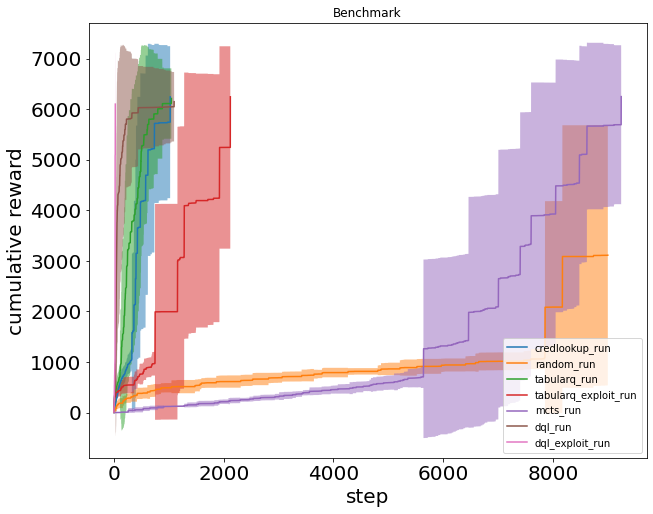

In [36]:
new_plot('Benchmark')
all_runs = [
    (credlookup_run['all_episodes_rewards'], 'credlookup_run'), 
    (random_run['all_episodes_rewards'], 'random_run'), 
    (tabularq_run['all_episodes_rewards'], 'tabularq_run'), 
    (tabularq_exploit_run['all_episodes_rewards'], 'tabularq_exploit_run'),
    (reward_records, 'mcts_run'),
    (dql_run['all_episodes_rewards'], 'dql_run'),
    (dql_exploit_run['all_episodes_rewards'], 'dql_exploit_run')
]
for r, r_title in all_runs:
    plot_episodes_rewards_averaged(r, r_title)
plt.legend(loc="lower right")
plt.show()

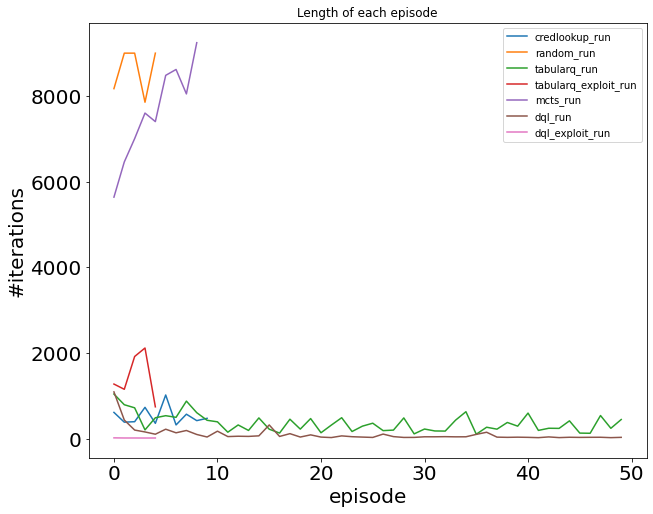

[6249.0, 6247.0, 6233.0, 6245.0, 6231.0, 6243.0, 6243.0, 6243.0, 6245.0, 6245.0]
[6257.0, 890.0, 1259.0, 6259.0, 892.0]
[6249.0, 6227.0, 6239.0, 6215.0, 6205.0, 6239.0, 6237.0, 6241.0, 6237.0, 6217.0, 6233.0, 6199.0, 6223.0, 6199.0, 6219.0, 6201.0, 6173.0, 6203.0, 6193.0, 6217.0, 6209.0, 6235.0, 6223.0, 6187.0, 6197.0, 6197.0, 6195.0, 6201.0, 6237.0, 6165.0, 6175.0, 6209.0, 6197.0, 6233.0, 6229.0, 6155.0, 6209.0, 6205.0, 6205.0, 6209.0, 6225.0, 6177.0, 6223.0, 6203.0, 6217.0, 6177.0, 6177.0, 6217.0, 6211.0, 6237.0]
[6243.0, 6249.0, 6251.0, 6249.0, 6247.0, 6241.0, 6247.0, 6251.0, 6247.0]
[6245.0, 6247.0, 6217.0, 6213.0, 6217.0, 6215.0, 6159.0, 6191.0, 6183.0, 6141.0, 6185.0, 6151.0, 6159.0, 6157.0, 6167.0, 6165.0, 6129.0, 6171.0, 6115.0, 6157.0, 6131.0, 6113.0, 6155.0, 6143.0, 6113.0, 6111.0, 6145.0, 6131.0, 6117.0, 6125.0, 6137.0, 6131.0, 6131.0, 6125.0, 6137.0, 6151.0, 6133.0, 6129.0, 6113.0, 6125.0, 6121.0, 6125.0, 6125.0, 6099.0, 6123.0, 6117.0, 6129.0, 6111.0, 6117.0, 6115.0]


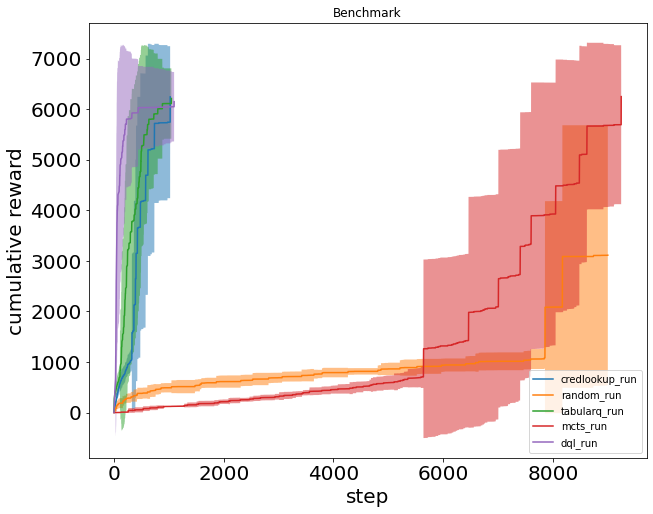

In [38]:
# new_plot('Benchmark')
all_runs = [
    {'all_episodes_rewards': credlookup_run['all_episodes_rewards'], 'title':'credlookup_run'}, 
    {'all_episodes_rewards': random_run['all_episodes_rewards'], 'title':'random_run'}, 
    {'all_episodes_rewards': tabularq_run['all_episodes_rewards'], 'title':'tabularq_run'}, 
    {'all_episodes_rewards': tabularq_exploit_run['all_episodes_rewards'], 'title':'tabularq_exploit_run'},
    {'all_episodes_rewards': reward_records, 'title':'mcts_run'},
    {'all_episodes_rewards': dql_run['all_episodes_rewards'], 'title':'dql_run'},
    {'all_episodes_rewards': dql_exploit_run['all_episodes_rewards'], 'title':'dql_exploit_run'}
]

plot_episodes_length(all_runs, 'Bench')
# plt.legend(loc="lower right")
plt.show()


new_plot('Benchmark')
all_runs = [
    (credlookup_run['all_episodes_rewards'], 'credlookup_run'), 
    (random_run['all_episodes_rewards'], 'random_run'), 
    (tabularq_run['all_episodes_rewards'], 'tabularq_run'), 
#     (tabularq_exploit_run['all_episodes_rewards'], 'tabularq_exploit_run'),
    (reward_records, 'mcts_run'),
    (dql_run['all_episodes_rewards'], 'dql_run'),
#     (dql_exploit_run['all_episodes_rewards'], 'dql_exploit_run')
]
for r, r_title in all_runs:
    plot_episodes_rewards_averaged(r, r_title)
plt.legend(loc="lower right")
plt.show()

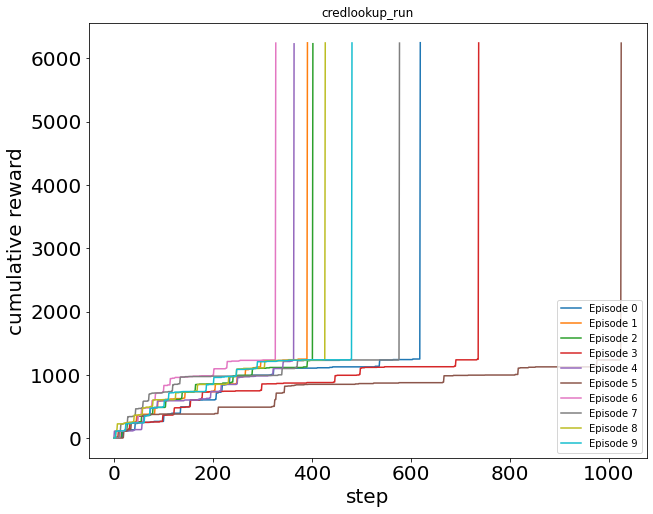

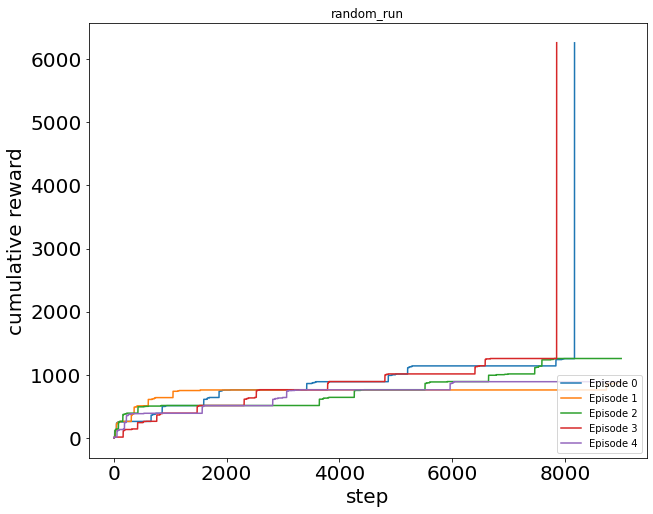

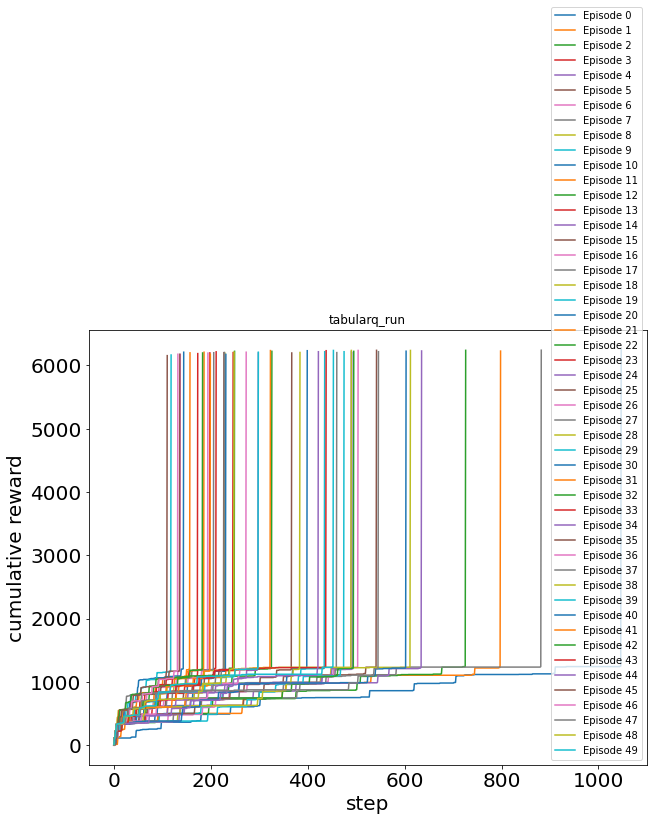

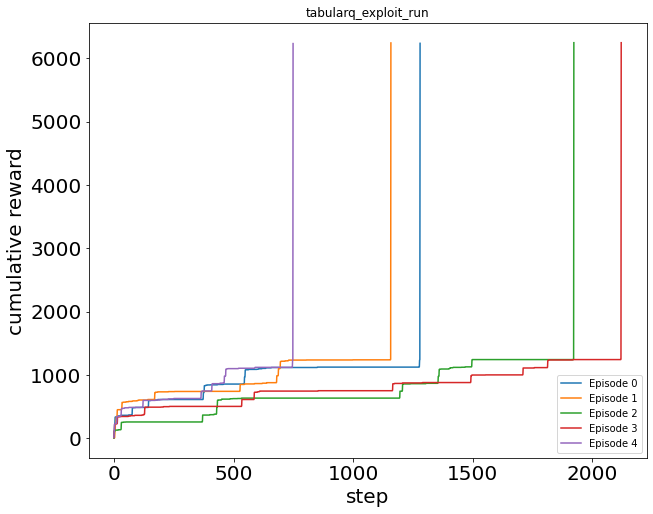

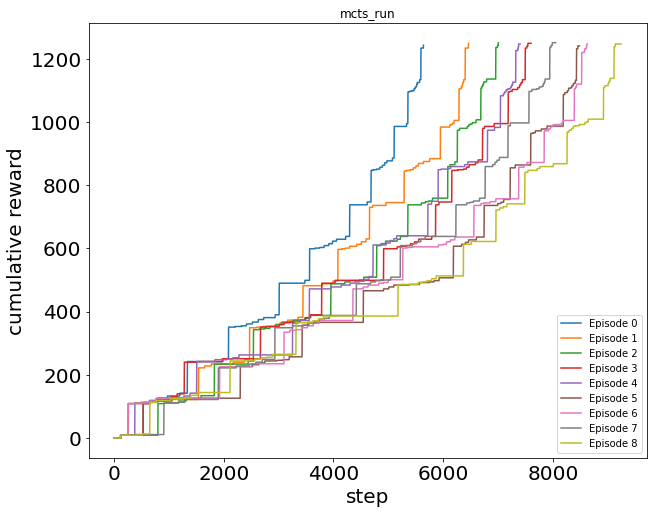

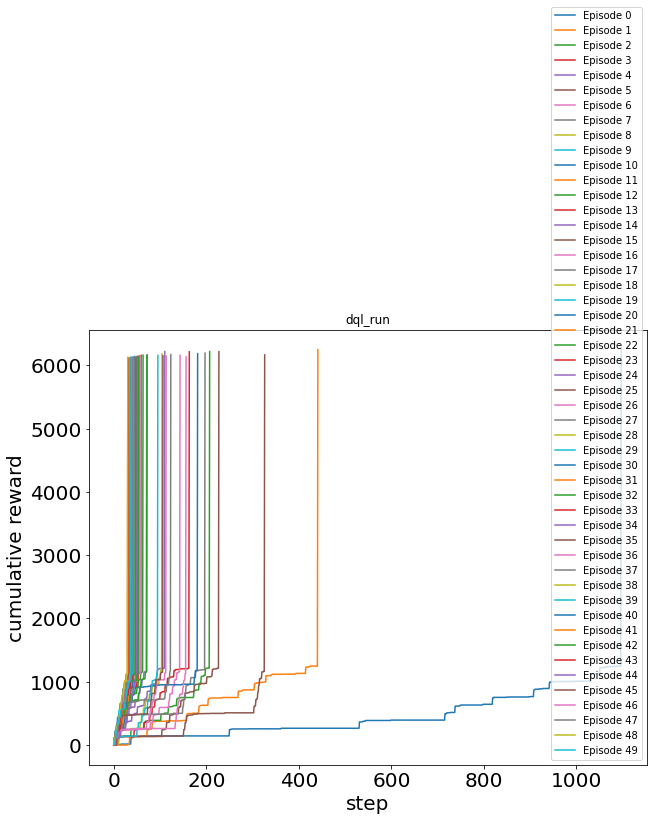

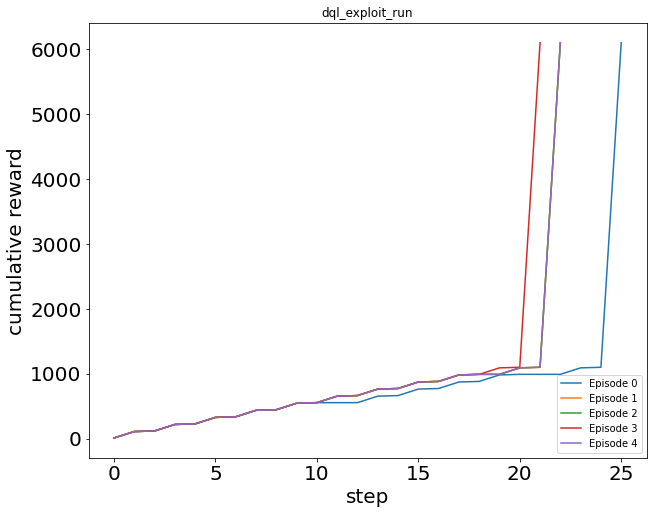

In [39]:
all_runs = [
    {'all_episodes_rewards': credlookup_run['all_episodes_rewards'], 'title':'credlookup_run'}, 
    {'all_episodes_rewards': random_run['all_episodes_rewards'], 'title':'random_run'}, 
    {'all_episodes_rewards': tabularq_run['all_episodes_rewards'], 'title':'tabularq_run'}, 
    {'all_episodes_rewards': tabularq_exploit_run['all_episodes_rewards'], 'title':'tabularq_exploit_run'},
    {'all_episodes_rewards': trimmed_rewards, 'title':'mcts_run'},
    {'all_episodes_rewards': dql_run['all_episodes_rewards'], 'title':'dql_run'},
    {'all_episodes_rewards': dql_exploit_run['all_episodes_rewards'], 'title':'dql_exploit_run'}
]
for r in all_runs:
    plot_all_episodes(r)
# plt.legend(loc="lower right")
plt.show()